In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


In [4]:
# Normalize image data
x_train = np.expand_dims(x_train, axis=-1)
x_train = x_train / 255.0
x_test = np.expand_dims(x_test, axis=-1)
x_test = x_test / 255.0


In [5]:
# Define model
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])


In [6]:
# Define model
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])


In [7]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Train model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1289 - accuracy: 0.9617 - val_loss: 0.0424 - val_accuracy: 0.9873
Epoch 2/5
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0440 - accuracy: 0.9864 - val_loss: 0.0396 - val_accuracy: 0.9879
Epoch 3/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.0316 - val_accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0327 - val_accuracy: 0.9904
Epoch 5/5
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0326 - val_accuracy: 0.9895


In [9]:
# Define a function to predict image based on the input integer value
def predict_image(num):
    # Create a blank black image with 28x28 resolution
    img = np.zeros((28,28))
    # Set the pixel value of the image based on the input integer value
    for i in range(0,28):
        for j in range(0,28):
            img[i][j] = num
    # Reshape the image to 28x28x1 and normalize its pixel values
    img = np.expand_dims(img, axis=-1)
    img = img / 255.0
    # Use the model to make a prediction on the input image
    prediction = model.predict(np.array([img]))
    # Return the predicted image
    return prediction


In [22]:
# Test the function by passing integer value 5 to it
predicted_image = predict_image(0)

1/1 [==============================] - 0s 17ms/step


In [23]:
predicted_image.shape

(1, 10)

In [24]:
predicted_image

array([[0.09841156, 0.10277198, 0.10362916, 0.10044613, 0.09791606,
        0.09852493, 0.09758113, 0.1010052 , 0.10358678, 0.09612709]],
      dtype=float32)

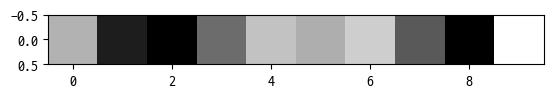

In [25]:
# Display the predicted image
plt.imshow(predicted_image, cmap=plt.cm.binary)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np

# MNIST 데이터 로드
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # 데이터를 -1에서 1사이로 normalize
x_train = np.expand_dims(x_train, axis=-1)  # 데이터를 4D로 변경

# 생성기와 판별기를 위한 하이퍼파라미터 설정
z_dim = 100
img_rows, img_cols, channels = 28, 28, 1

# 생성기 정의
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(256, input_dim=z_dim))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((img_rows, img_cols, channels)))
    return model

# 판별기 정의
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Input(shape=(img_rows, img_cols, channels)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(Dense(256))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN 모델을 정의하고 훈련시키는 함수
def train_gan(generator, discriminator, epochs=1000, batch_size=256):
    # GAN 정의
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator.trainable = True
    discriminator.trainable = False

    gan_input = Input(shape=(z_dim,))
    gan_output = discriminator(generator(gan_input))
    
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    # GAN 훈련
    for epoch in range(epochs):
        # 구분자 훈련
        discriminator.trainable = True
        indices = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[indices]
        real_labels = np.ones((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자 훈련
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        # 상태 출력
        if epoch % 100 == 0:
            print(f'epoch: {epoch}/{epochs}, d_loss: {d_loss}, g_loss: {g_loss}')

# 실행
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

train_gan(generator, discriminator)


In [ ]:
import matplotlib.pyplot as plt

def generate_digit_image(digit):
    noise = np.random.normal(0, 1, (1, z_dim))
    conditioned_noise = np.hstack((noise, np.array(digit).reshape(1, -1)))
    image = generator.predict(conditioned_noise)
    image = (image * 127.5 + 127.5).astype(np.uint8).reshape(28, 28)
    return image

# 예시
digit = 3
generated_image = generate_digit_image(digit)
plt.imshow(generated_image, cmap='gray')
plt.show()


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [33]:
# MNIST 데이터 로드
(x_train, y_train), (_, _) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # 데이터를 -1에서 1사이로 normalize
x_train = np.expand_dims(x_train, axis=-1)  # 데이터를 4D로 변경

num_classes = 10

# 라벨 정보를 원-핫 인코딩으로 변환
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

# 생성기와 판별기를 위한 하이퍼파라미터 설정
z_dim = 100
img_rows, img_cols, channels = 28, 28, 1

In [30]:
# 생성기 정의
def build_generator():
    # 노이즈 입력
    noise_input = Input(shape=(z_dim,))
    dense_noise = Dense(128, activation='relu')(noise_input)
    
    # 라벨 정보 입력
    label_input = Input(shape=(num_classes,))
    dense_label = Dense(128, activation='relu')(label_input)
    
    # 노이즈와 라벨 정보를 합침
    concat = Concatenate()([dense_noise, dense_label])
    
    model = Dense(256, activation='relu')(concat)
    model = Dense(512, activation='relu')(model)
    model = Dense(784, activation='tanh')(model)
    model = Reshape((img_rows, img_cols, channels))(model)
    
    return Model([noise_input, label_input], model)

# 판별기 정의
def build_discriminator():
    # 이미지 입력
    img_input = Input(shape=(img_rows, img_cols, channels))
    flatten_img = Flatten()(img_input)
    
    # 라벨 정보 입력
    label_input = Input(shape=(num_classes,))
    dense_label = Dense(784)(label_input)
    
    # 이미지와 라벨 정보를 합침
    concat = Concatenate()([flatten_img, dense_label])
    
    model = Dense(512, activation='relu')(concat)
    model = Dense(256, activation='relu')(model)
    model = Dense(1, activation='sigmoid')(model)
    
    return Model([img_input, label_input], model)

# cGAN 모델 정의 및 훈련 함수
def train_cgan(generator, discriminator, epochs=1000, batch_size=256):
    # GAN 정의
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    generator.trainable = True
    discriminator.trainable = False

    noise_input = Input(shape=(z_dim,))
    label_input = Input(shape=(num_classes,))
    gan_output = discriminator([generator([noise_input, label_input]), label_input])
    
    gan = Model([noise_input, label_input], gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    # 훈련 시작
    for epoch in range(epochs):
        # 판별기 훈련
        discriminator.trainable = True
        indices = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[indices]
        real_labels = y_train[indices]
        real_targets = np.ones((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_images, real_labels], real_targets)
        
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        random_labels = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, batch_size), num_classes)
        fake_images = generator.predict([noise, random_labels])
        fake_targets = np.zeros((batch_size, 1))
        
        d_loss_fake = discriminator.train_on_batch([fake_images, random_labels], fake_targets)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자 훈련
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        random_labels = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, batch_size), num_classes)
        real_targets = np.ones((batch_size, 1))
        
        g_loss = gan.train_on_batch([noise, random_labels], real_targets)

        # 진행 상황 출력
        if epoch % 100 == 0:
            print(f'epoch: {epoch}/{epochs}, d_loss: {d_loss}, g_loss: {g_loss}')


In [ ]:
# 실행
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

train_cgan(generator, discriminator)

In [31]:
import matplotlib.pyplot as plt

def generate_digit_image(digit):
    noise = np.random.normal(0, 1, (1, z_dim))
    label = tf.keras.utils.to_categorical(digit, num_classes).reshape((1, num_classes))
    generated_image = generator.predict([noise, label])
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8).reshape(28, 28)
    return generated_image

In [ ]:
# 예시
digit = 2
generated_image = generate_digit_image(digit)
plt.imshow(generated_image, cmap='gray')
plt.show()

In [ ]:
# 훈련 완료된 모델 저장
generator.save('cgan_generator.h5')

In [34]:
# 모델 불러오기
from tensorflow.keras.models import load_model
generator = load_model(r'./data/cgan_generator.h5')

1/1 [==============================] - 0s 18ms/step


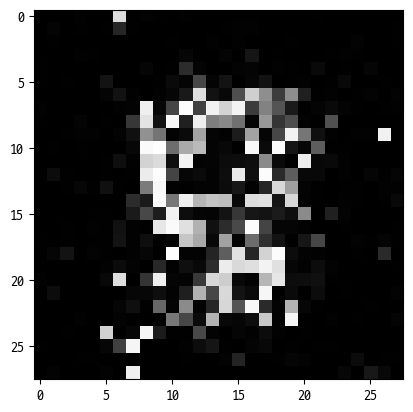

In [39]:
# 불러온 모델로 이미지 생성
digit = 0
generated_image = generate_digit_image(digit)
plt.imshow(generated_image, cmap='gray')

1/1 [==============================] - 0s 15ms/step


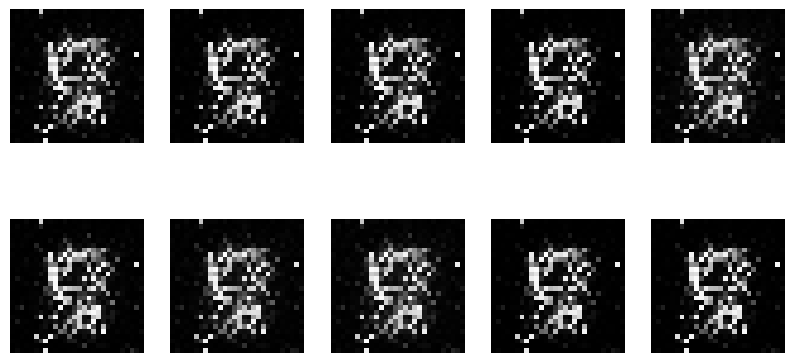

In [44]:
digits = range(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for d in digits:
    axes[d // 5, d % 5].imshow(generate_digit_image(d), cmap='gray')
    axes[d // 5, d % 5].axis('off')

1/1 [==============================] - 0s 33ms/step


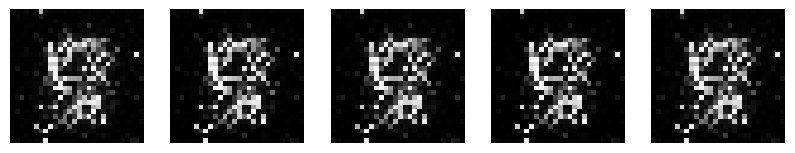

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def generate_digit_image(generator, digit, num_images=1):
    z_dim = generator.input_shape[0][1]
    num_classes = generator.input_shape[1][1]

    if digit < 0 or digit >= num_classes:
        print('Invalid digit.')
        return

    noise = np.random.normal(0, 1, (num_images, z_dim))
    label_input = np.zeros((num_images, num_classes))
    label_input[:, digit] = 1

    generated_images = generator.predict([noise, label_input])
    return generated_images

def show_generated_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))

    for i, img in enumerate(images):
        axes[i].imshow((img * 0.5 + 0.5), cmap='gray')
        axes[i].axis('off')

    plt.show()

# 특정 숫자 이미지 생성
digit = 2  # 원하는 숫자
num_images = 5  # 생성할 이미지 개수
generated_images = generate_digit_image(generator, digit, num_images)

# 생성된 이미지 표시
show_generated_images(generated_images)
